# Chap 12 - Ex2: cluster customers into group using ageinc_g.csv.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

np.set_printoptions(suppress = True)

In [2]:
customer = pd.read_csv('Data/ageinc_g.csv', index_col = 0)
customer

,income,age,gender
0,101743,58,Female
1,49597,27,Female
2,36517,52,Male
3,33223,49,Male
4,72994,53,Female
...,...,...,...
995,70615,29,Female
996,95102,41,Female
997,42203,35,Male
998,16975,31,Female


In [3]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   income  1000 non-null   int64 
 1   age     1000 non-null   int64 
 2   gender  1000 non-null   object
dtypes: int64(2), object(1)
memory usage: 31.2+ KB


In [4]:
customer.describe()

,income,age
count,1000.00000,1000.000000
mean,80116.81800,39.410000
std,39262.33567,10.976811
min,0.00000,18.000000
25%,46402.25000,30.000000
50%,78993.50000,39.000000
75%,114810.50000,49.000000
max,179294.00000,63.000000


income ___ ShapiroResult(statistic=0.95244171092576, pvalue=1.8452768011280746e-17)
age ___ ShapiroResult(statistic=0.9490401537479766, pvalue=4.221272310083379e-18)



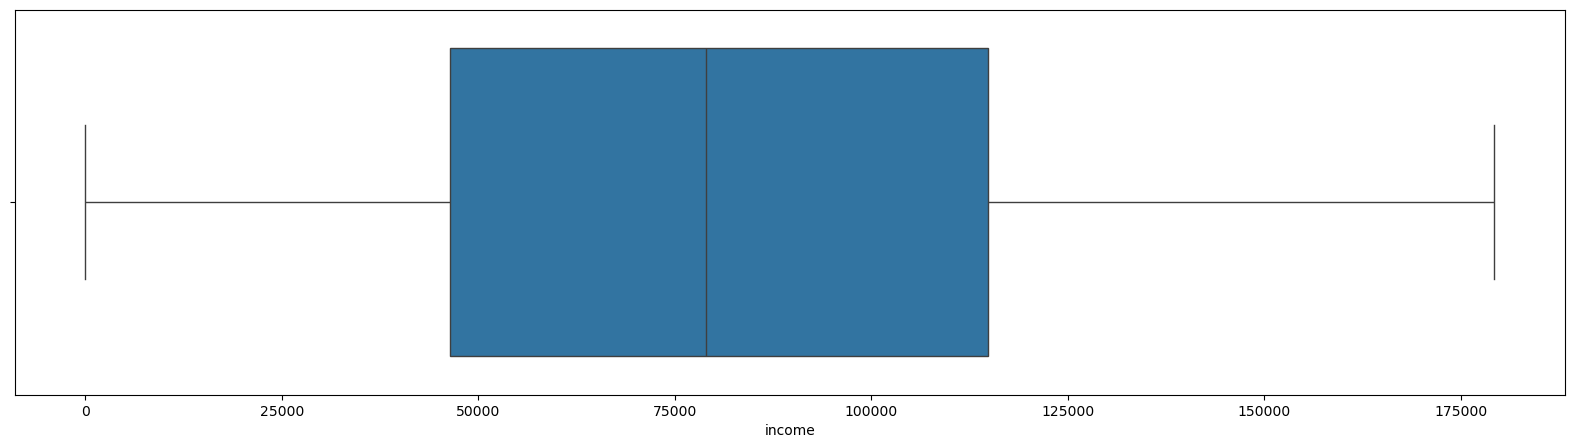

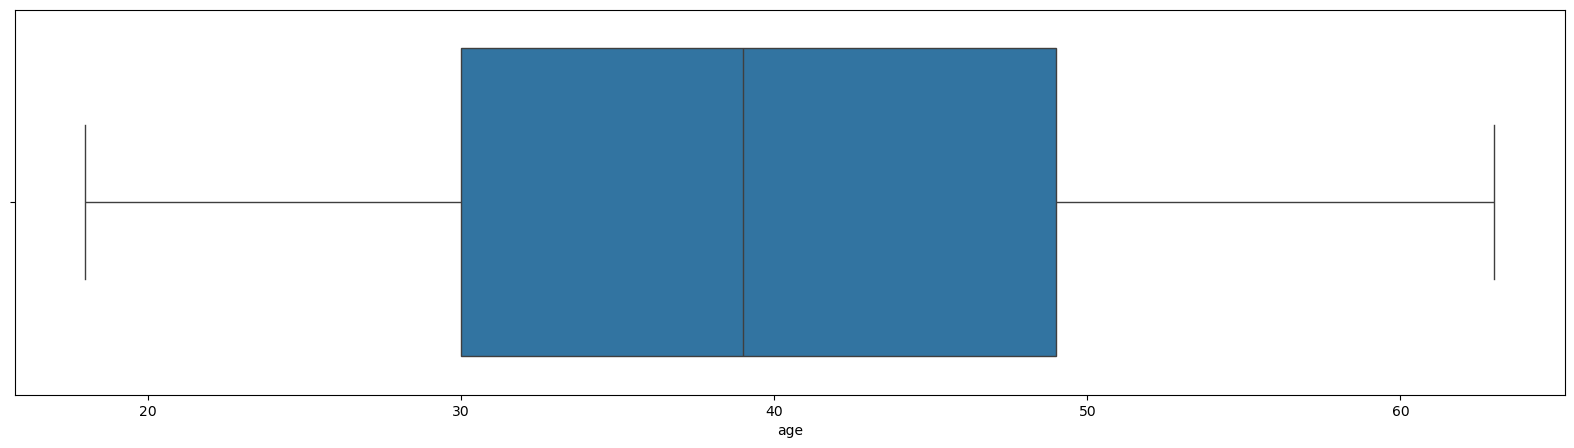

In [5]:
from scipy.stats import shapiro

for num_feat in customer.select_dtypes(exclude='object').columns:
    print(f'{num_feat} ___ {shapiro(customer[num_feat])}')
print()

for num_feat in customer.select_dtypes(exclude='object').columns:
    plt.figure(figsize=(20,5))
    sbn.boxplot(data = customer, x = num_feat)
    plt.show()

## <span style = 'color:yellow'> Find optimal number of clusters K 

In [6]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from imblearn.pipeline import Pipeline

categ_feats = list(customer.select_dtypes(include = 'object').columns)

k_nums = range(2,11)

data = customer.copy()

for k in k_nums:
    hierclust_pipe = Pipeline([
        ('OneHotEncoder', make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), categ_feats), remainder='passthrough')),
        ('MinMaxScaler', MinMaxScaler()),
        ('HierachichalClustering', AgglomerativeClustering(n_clusters = k))
    ])
    hierclust_pipe.fit(data)
    data_scaled = (
        pd.DataFrame(hierclust_pipe[:-1].transform(data)) #Transform original data with onehotencoder and MinMaxScaler
        .pipe(lambda df: df.set_axis(hierclust_pipe.named_steps['OneHotEncoder'].get_feature_names_out(), axis =1))
    )
    labels = hierclust_pipe.named_steps['HierachichalClustering'].labels_
    print(f'Silhouette score for k = {k}: {silhouette_score(data_scaled, labels)}')

print(f'\nChoose K = 2')

Silhouette score for k = 2: 0.6214218944532653
Silhouette score for k = 3: 0.5045329278986207
Silhouette score for k = 4: 0.4129159306459127
Silhouette score for k = 5: 0.4198126613091757
Silhouette score for k = 6: 0.4576101127755657
Silhouette score for k = 7: 0.4634289606062847
Silhouette score for k = 8: 0.48428496167402346
Silhouette score for k = 9: 0.4658433695437726
Silhouette score for k = 10: 0.4335828504330285

Choose K = 2


## <span style = 'color:yellow'> Create drawing heatmap function

In [8]:
### Create function
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_clustered_heatmap(data, model, title="Clustered Heatmap"):
    """
    Plots a clustered heatmap from AgglomerativeClustering outputs.

    Args:
        data: The original data (DataFrame or NumPy array).
        model: Fitted AgglomerativeClustering model.
        title: Title of the plot.
    """

    # Create linkage matrix
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Reorder the data based on clustering
    if isinstance(data, pd.DataFrame):
        ordered_indices = model.labels_
        ordered_data = data.iloc[np.argsort(ordered_indices)]
    else:
        ordered_indices = model.labels_
        ordered_data = data[np.argsort(ordered_indices)]

    # Plot the clustered heatmap
    fig = sbn.clustermap(ordered_data, row_linkage=linkage_matrix, col_cluster=False, figsize=(10, 10), cmap="viridis", cbar_pos=(0.02, 0.8, 0.03, 0.15))
    fig.ax_heatmap.set_title(title)
    plt.show()

## <span style = 'color:yellow'> Build AgglomerativeClustering with k = 2 (heatmap with Non-Scaled data)

Non-Scaled data for plotting:
      gender_Male    income   age  Group
0            0.0  101743.0  58.0      0
1            0.0   49597.0  27.0      1
2            1.0   36517.0  52.0      1
3            1.0   33223.0  49.0      1
4            0.0   72994.0  53.0      1
..           ...       ...   ...    ...
995          0.0   70615.0  29.0      1
996          0.0   95102.0  41.0      0
997          1.0   42203.0  35.0      1
998          0.0   16975.0  31.0      1
999          1.0  123857.0  44.0      0

[1000 rows x 4 columns]



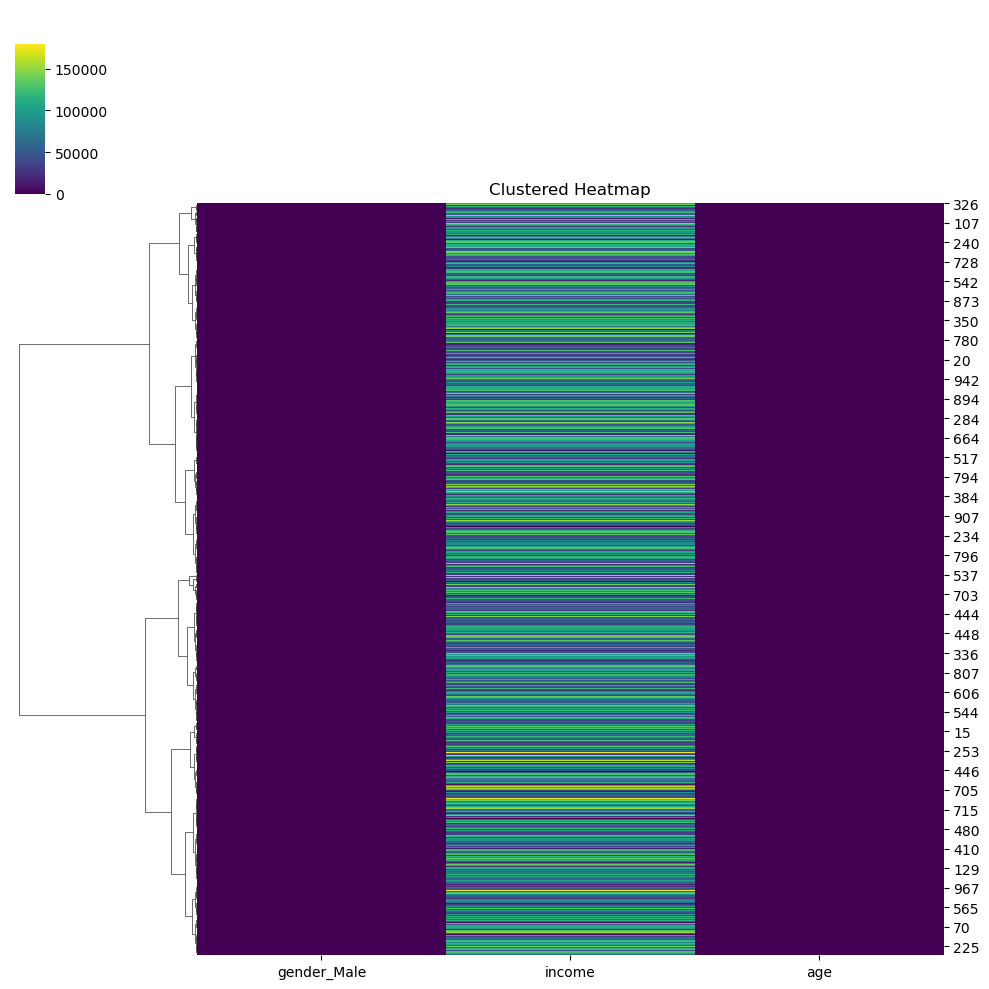

In [30]:
hierclust_pipe = Pipeline([
    ('OneHotEncoder', make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), categ_feats), remainder='passthrough')),
    #('MinMaxScaler', MinMaxScaler()),
    ('HierachichalClustering', AgglomerativeClustering(n_clusters = 2, compute_distances=True))
])
hierclust_pipe.fit(data)
data_scaled = (
    pd.DataFrame(hierclust_pipe.named_steps['OneHotEncoder'].transform(data)) #Transform original data with onehotencoder
    #.pipe(lambda df: pd.DataFrame(hierclust_pipe.named_steps['MinMaxScaler'].transform(df))) #Transform original data with MinMaxScaler
    .pipe(lambda df: df.set_axis(hierclust_pipe.named_steps['OneHotEncoder'].get_feature_names_out(), axis =1))
)
labels = hierclust_pipe.named_steps['HierachichalClustering'].labels_

data_scaled.columns = [col.replace('onehotencoder__', '').replace('remainder__', '') for col in data_scaled.columns]
data_scaled['Group'] = labels

print('Non-Scaled data for plotting:\n',data_scaled)
print()

plot_clustered_heatmap(data_scaled.iloc[:,:-1], hierclust_pipe.named_steps['HierachichalClustering'])

## <span style = 'color:yellow'> Build AgglomerativeClustering with k = 2 (heatmap with Scaled data)

Scaled data for plotting:
      gender_Male    income       age  Group
0            0.0  0.567465  0.888889      1
1            0.0  0.276624  0.200000      1
2            1.0  0.203671  0.755556      0
3            1.0  0.185299  0.688889      0
4            0.0  0.407119  0.777778      1
..           ...       ...       ...    ...
995          0.0  0.393850  0.244444      1
996          0.0  0.530425  0.511111      1
997          1.0  0.235384  0.377778      0
998          0.0  0.094677  0.288889      1
999          1.0  0.690804  0.577778      0

[1000 rows x 4 columns]



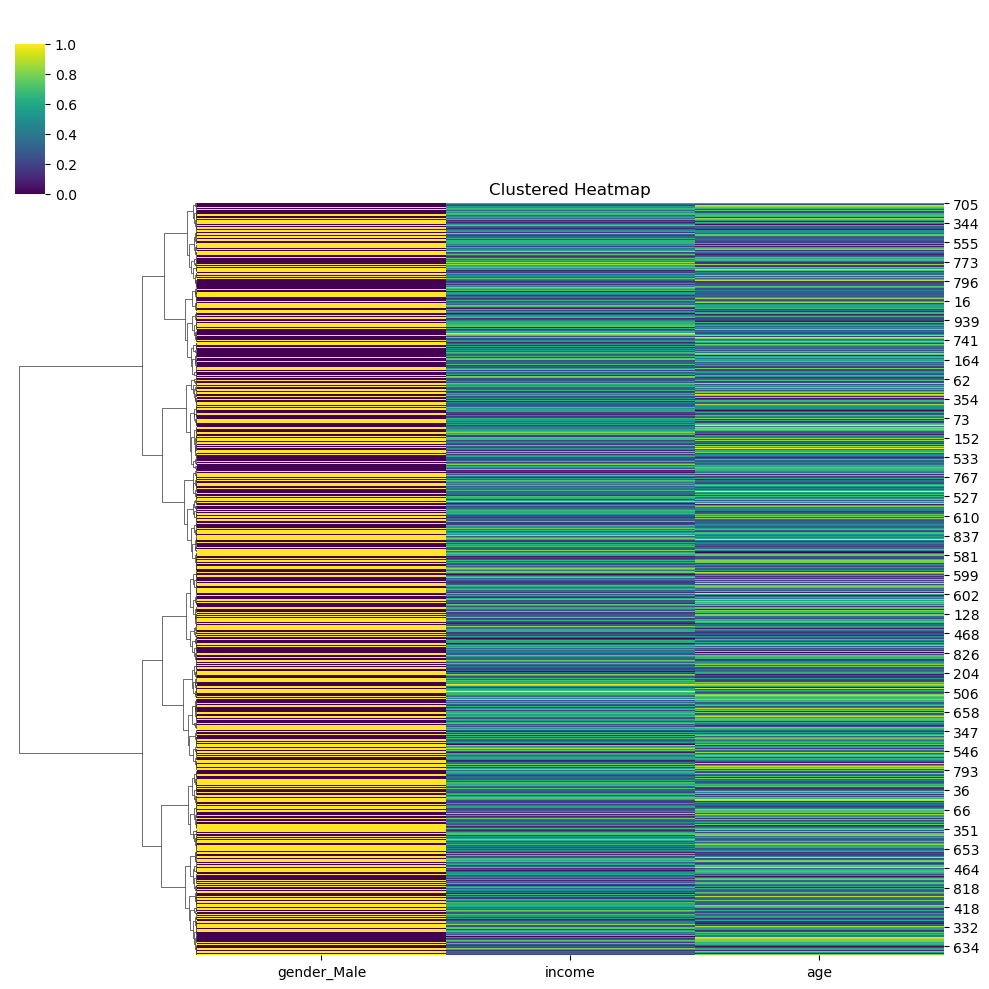

In [9]:
hierclust_pipe = Pipeline([
    ('OneHotEncoder', make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), categ_feats), remainder='passthrough')),
    ('MinMaxScaler', MinMaxScaler()),
    ('HierachichalClustering', AgglomerativeClustering(n_clusters = 2, compute_distances=True))
])
hierclust_pipe.fit(data)
data_scaled = (
    pd.DataFrame(hierclust_pipe[:-1].transform(data)) #Transform original data with onehotencoder and MinMaxScaler
    .pipe(lambda df: df.set_axis(hierclust_pipe.named_steps['OneHotEncoder'].get_feature_names_out(), axis =1))
)
labels = hierclust_pipe.named_steps['HierachichalClustering'].labels_

data_scaled.columns = [col.replace('onehotencoder__', '').replace('remainder__', '') for col in data_scaled.columns]
data_scaled['Group'] = labels

print('Scaled data for plotting:\n',data_scaled)
print()

plot_clustered_heatmap(data_scaled.iloc[:,:-1], hierclust_pipe.named_steps['HierachichalClustering'])

# <span style = 'color:yellow'> Report clustering results:

In [39]:
data_group = hierclust_pipe.named_steps['OneHotEncoder'].transform(customer.copy())
data_group = pd.DataFrame(data_group, columns = hierclust_pipe.named_steps['OneHotEncoder'].get_feature_names_out())
data_group.columns = [col.replace('onehotencoder__', '').replace('remainder__', '') for col in data_group.columns]
data_group['Group'] = labels

for group in data_group['Group'].unique():
    print(f'\n=============== Cluster group {group} =========================\n')
    data = data_group[data_group['Group'] == group]
    print(f'n_observations: {data.shape[0]}\n')
    for col_name in data.columns[:-1]:
        if col_name in ['gender_Male']:
            print(f'{data[col_name].value_counts().to_frame().reset_index()}')
            print()
        else:
            print(f'{col_name}: {np.min(data[col_name])} ~ {np.median(data[col_name])} ~ {np.max(data[col_name])}')
            print()


=============== Cluster group 1 =========================

n_observations: 489

   gender_Male  count
0          0.0    489

income: 0.0 ~ 71181.0 ~ 179294.0

age: 18.0 ~ 40.0 ~ 63.0


=============== Cluster group 0 =========================

n_observations: 511

   gender_Male  count
0          1.0    511

income: 0.0 ~ 89117.0 ~ 175073.0

age: 18.0 ~ 39.0 ~ 61.0



Number of numeric fields: 2

All numeric fields: ['income', 'age']



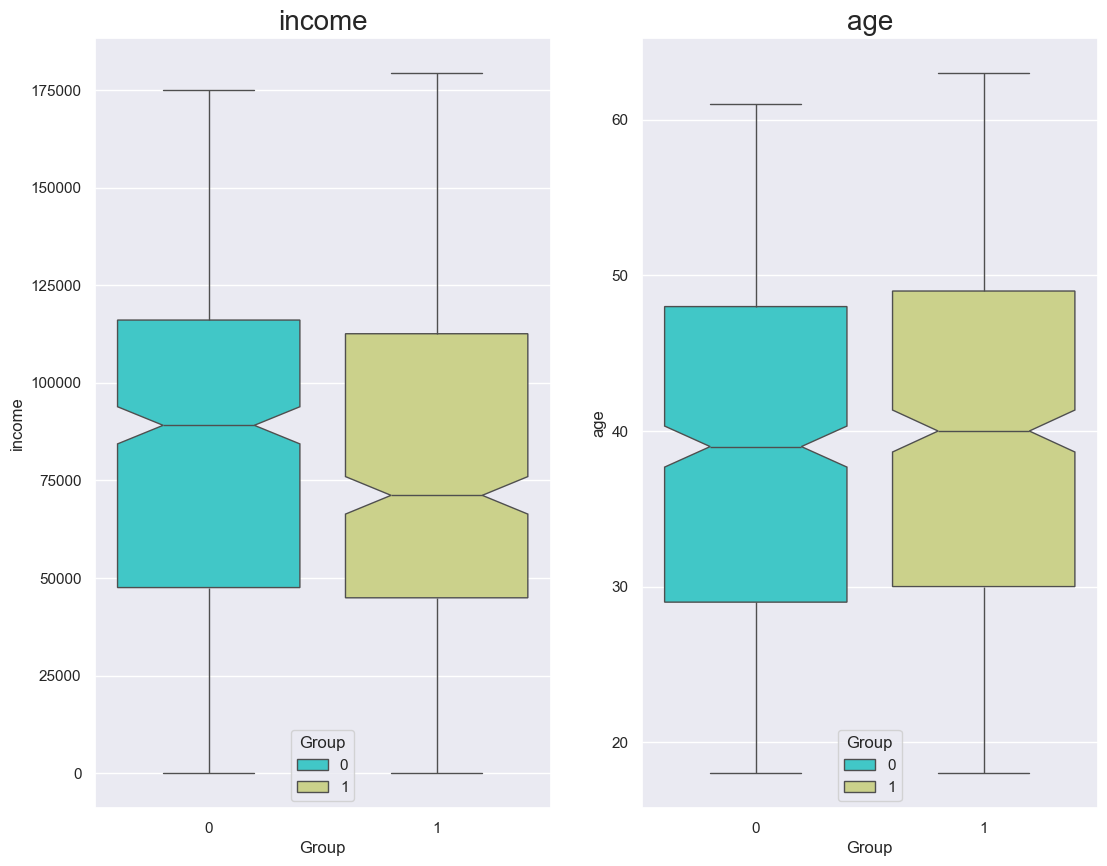


-----------------------------------------------------------------------------------------------------------------------------

Number of categorical fields: 1

All categorical fields: ['gender_Male']



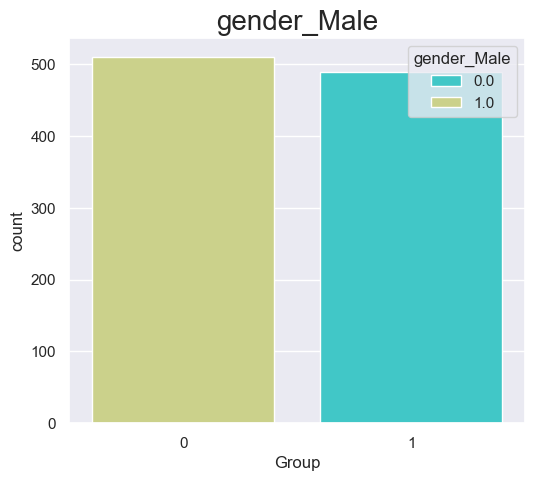

In [45]:
numeric_cols = ['income', 'age']
categ_cols = ['gender_Male']

##### Function building ##############

def boxplot_numeric(df, numeric_cols, figsize=(20, 10), groups = None):
    col = 3
    if (len(numeric_cols) % 3) == 0:
        row = len(numeric_cols) // 3
    else:
        row = (len(numeric_cols) // 3) + 1
    '''
    numeric_cols: list các tên cột biến định lượng
    row: số lượng dòng trong lưới đồ thị
    col: số lượng cột trong lưới đồ thị
    figsize: kích thước biểu đồ
    groups: tên cột chứa biến phân nhóm như 'Group' hoặc 'Class' hoặc 'Label'
    '''
    print(f'Number of numeric fields: {len(numeric_cols)}')
    print()
    print(f'All numeric fields: {numeric_cols}')
    print()
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        sbn.boxplot(data = df, x = groups, y = numeric_cols[i-1], notch = True, hue = groups, palette = 'rainbow')
        plt.title(numeric_cols[i-1], size = 20)
      except:
        print('Error {}'.format(numeric_cols[i-1]))
        break
    plt.show()


def countplot_categ(df, categ_cols, figsize=(20, 5), groups = None):
    col = 3
    if (len(categ_cols) % 3) == 0:
        row = len(categ_cols) // 3
    else:
        row = (len(categ_cols) // 3) + 1
    '''
    categ_cols: list các tên cột biến định tính
    row: số lượng dòng trong lưới đồ thị
    col: số lượng cột trong lưới đồ thị
    figsize: kích thước biểu đồ
    groups: tên cột chứa biến phân nhóm như 'Group' hoặc 'Class' hoặc 'Label'
    '''
    print(f'Number of categorical fields: {len(categ_cols)}')
    print()
    print(f'All categorical fields: {categ_cols}')
    print()
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    for i in range(1, len(categ_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        sbn.countplot(data = df, x = groups, hue = categ_cols[i-1], palette = 'rainbow')
        plt.title(categ_cols[i-1], size = 20)
      except:
        print('Error {}'.format(categ_cols[i-1]))
        break
    plt.show()

## Draw
sbn.set_theme(style ='darkgrid')
boxplot_numeric(data_group, numeric_cols, groups = data_group.iloc[:,-1])
print('\n-----------------------------------------------------------------------------------------------------------------------------\n')
countplot_categ(data_group, categ_cols, groups = data_group.iloc[:,-1])

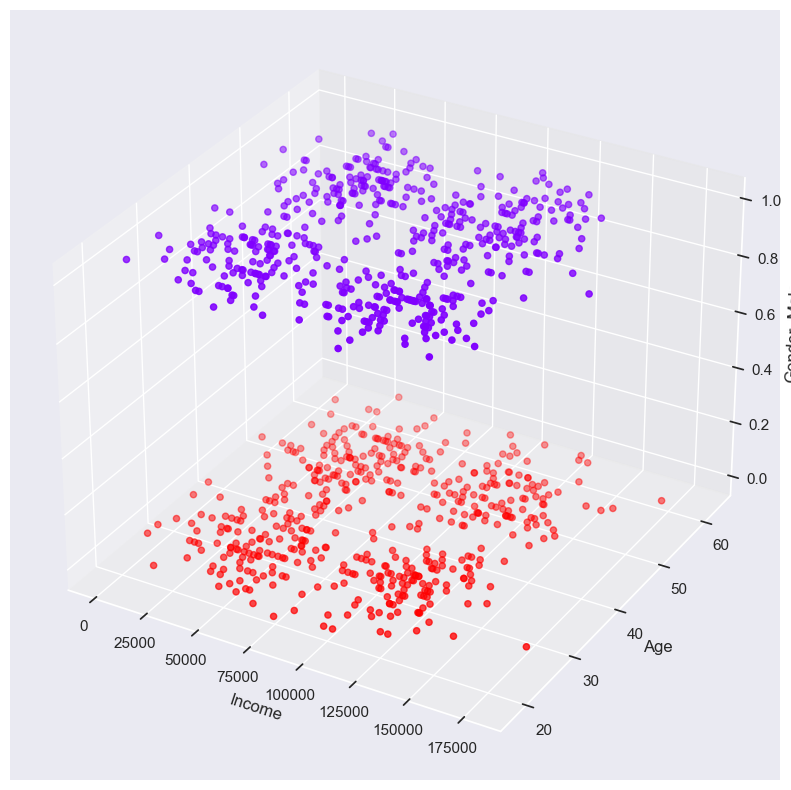

In [47]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(xs = data_group['income'],
          ys = data_group['age'],
          zs = data_group['gender_Male'],
          c = data_group['Group'], cmap = 'rainbow')
ax.set_xlabel('Income')
ax.set_ylabel('Age')
ax.set_zlabel('Gender_Male')
plt.show()

## <span style = 'color:yellow'> Build AgglomerativeClustering with k = 3 (heatmap with Scaled data)

Scaled data for plotting:
      gender_Male    income       age  Group
0            0.0  0.567465  0.888889      0
1            0.0  0.276624  0.200000      0
2            1.0  0.203671  0.755556      2
3            1.0  0.185299  0.688889      2
4            0.0  0.407119  0.777778      0
..           ...       ...       ...    ...
995          0.0  0.393850  0.244444      0
996          0.0  0.530425  0.511111      0
997          1.0  0.235384  0.377778      1
998          0.0  0.094677  0.288889      0
999          1.0  0.690804  0.577778      2

[1000 rows x 4 columns]



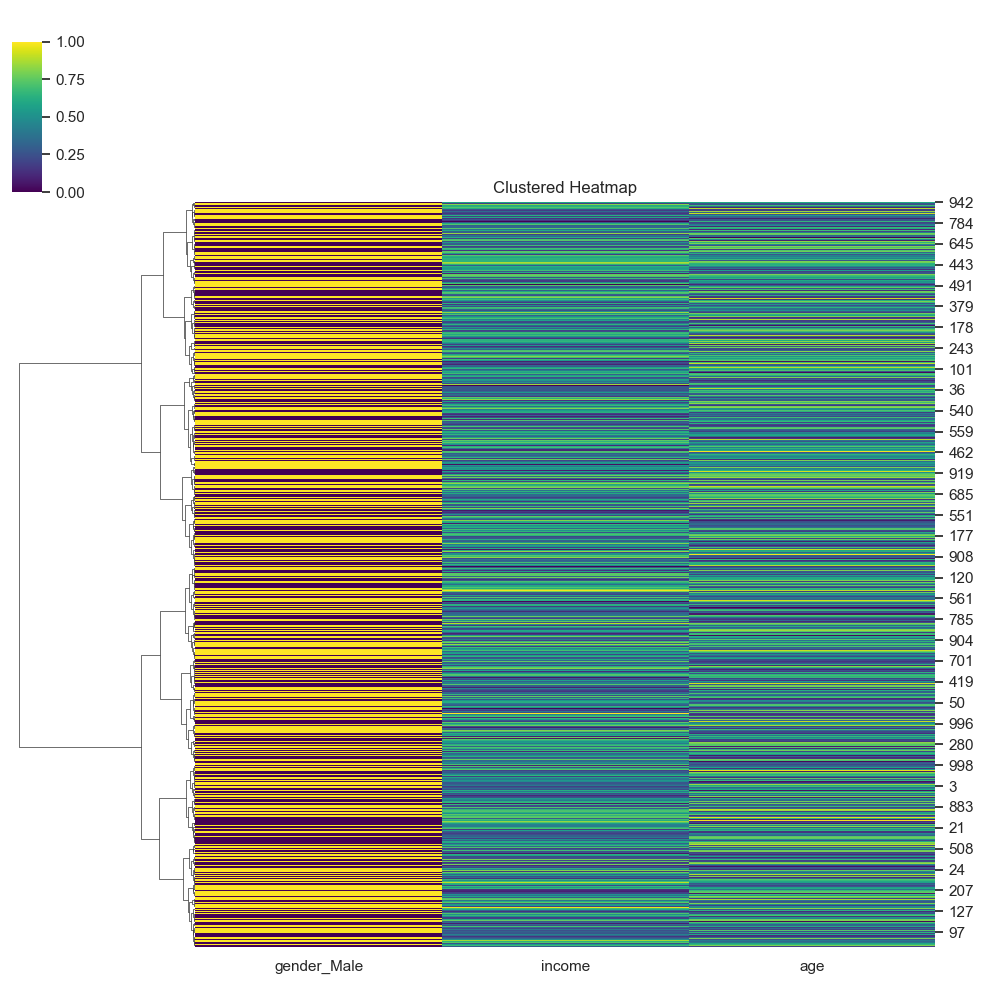

In [43]:
hierclust_pipe_scale = Pipeline([
    ('OneHotEncoder', make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), categ_feats), remainder='passthrough')),
    ('MinMaxScaler', MinMaxScaler()),
    ('HierachichalClustering', AgglomerativeClustering(n_clusters = 3, compute_distances = True, metric = 'euclidean', linkage ='ward'))
])
hierclust_pipe_scale.fit(customer)
labels = hierclust_pipe_scale.named_steps['HierachichalClustering'].labels_

data_plot = hierclust_pipe_scale.named_steps['OneHotEncoder'].transform(customer.copy())
data_plot = hierclust_pipe_scale.named_steps['MinMaxScaler'].transform(data_plot) #Scale the data before plotting
data_plot = pd.DataFrame(data_plot, columns = hierclust_pipe_scale.named_steps['OneHotEncoder'].get_feature_names_out())
data_plot.columns = [col.replace('onehotencoder__', '').replace('remainder__', '') for col in data_plot.columns]
data_plot['Group'] = labels

print('Scaled data for plotting:\n',data_plot)
print()

plot_clustered_heatmap(data_plot.iloc[:,:-1], hierclust_pipe_scale.named_steps['HierachichalClustering'])

## Even with K = 3, the visualized clustered-heatmap still shows only 2 clusters, meaning the distance from the cluster 3 to the others is too small, so it appears to be in these cluster 1 and 2